In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dropout, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, AvgPool2D, MaxPool2D


(-0.5, 511.5, 511.5, -0.5)

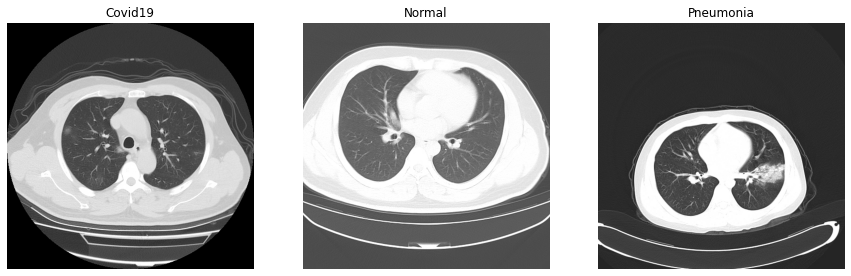

In [2]:
# dataset
input_dir = '../input/covid19normalpneumonia-ct-images'

c19_img = '../input/covid19normalpneumonia-ct-images/COVID2_CT/21.jpg'
nor_img = '../input/covid19normalpneumonia-ct-images/Normal_CT/23985k (1).jpg'
pne_img = '../input/covid19normalpneumonia-ct-images/pneumonia_CT/8 (10).jpg'


plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cv2.imread(c19_img))
plt.title('Covid19')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.imread(nor_img))
plt.title('Normal')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.imread(pne_img))
plt.title('Pneumonia')
plt.axis('off')

In [3]:
# some constant values
img_size = (256,256)
batch_size = 64
input_shape = (256,256,3)
no_of_epoch = 20

In [4]:
# Image preprocessing

idg = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.25)


train_data = idg.flow_from_directory(input_dir, target_size=img_size, batch_size=batch_size, subset='training')
val_data = idg.flow_from_directory(input_dir, target_size=img_size, batch_size=batch_size, subset='validation', shuffle=False)


Found 5660 images belonging to 3 classes.
Found 1884 images belonging to 3 classes.


In [5]:
# callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("./SavedModel.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max', period=1)

In [6]:
# Model

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))


model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(3,activation="softmax"))

In [7]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()
print('Total layers = ', len(model.layers))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<img src="model_diag.png"/>

In [8]:
hist = model.fit_generator(train_data, steps_per_epoch=train_data.samples//batch_size, validation_data=val_data,validation_steps=val_data.samples//batch_size, epochs=no_of_epoch, callbacks=[checkpoint])

Epoch 1/20
88/88 [==============================] - ETA: 0s - loss: 1.4321 - accuracy: 0.4480 - precision: 0.5007 - recall: 0.1228
Epoch 00001: val_accuracy improved from -inf to 0.54256, saving model to ./SavedModel.hdf5
88/88 [==============================] - 803s 9s/step - loss: 1.4321 - accuracy: 0.4480 - precision: 0.5007 - recall: 0.1228 - val_loss: 0.8936 - val_accuracy: 0.5426 - val_precision: 0.6432 - val_recall: 0.2953
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 1.5210 - accuracy: 0.5868 - precision: 0.6515 - recall: 0.4042
Epoch 00002: val_accuracy improved from 0.54256 to 0.60884, saving model to ./SavedModel.hdf5
88/88 [==============================] - 802s 9s/step - loss: 1.5210 - accuracy: 0.5868 - precision: 0.6515 - recall: 0.4042 - val_loss: 0.8354 - val_accuracy: 0.6088 - val_precision: 0.6537 - val_recall: 0.5065
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.6808 - precision: 0.7224 - recall: 0.611

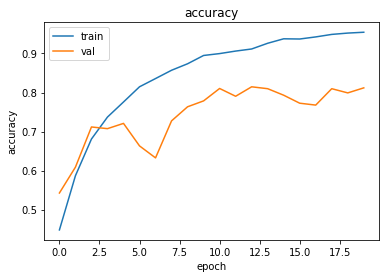

In [9]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.legend(('train', 'val'))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

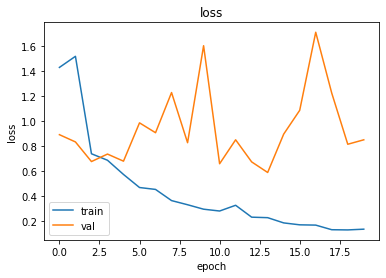

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.legend(('train', 'val'))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

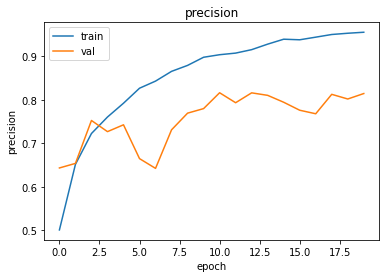

In [12]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('precision')
plt.legend(('train', 'val'))
plt.ylabel('precision')
plt.xlabel('epoch')
plt.show()

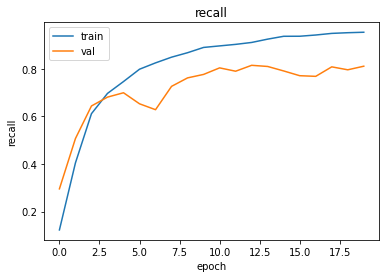

In [13]:
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('recall')
plt.legend(('train', 'val'))
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()

In [11]:
# model will be saved when best validation accuracy is reached.